In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.integrate as integrate
from sklearn.isotonic import IsotonicRegression
from datetime import datetime

## Model Parameters and Quality Sampling

In [2]:
class ThresholdConfParams:
    def __init__(self, n, mu_q, sig_q, sig_r):
        self.n = n            # number of papers
        self.mu_q = mu_q      # mean of quality prior
        self.sig_q = sig_q    # std of quality prior
        self.sig_r = sig_r    # std of review noise
        
        
# draw samples from quality distribution
def sample_q(para, nmc):
    samples = np.random.normal(loc=para.mu_q, scale=para.sig_q, size=(nmc,para.n))
    return np.sort(samples, axis = 1, kind='quicksort')[:,::-1]

## Threshold Sequential Mechanism

In [3]:
def sequential_quality(para, q, t_acc, t_rev):
    nmc = np.size(q, axis = 0)
    n = para.n
    sig_r = para.sig_r
    
    q_acc = np.zeros(nmc)
    q_rev = np.zeros(nmc)
    n_rev = np.zeros(nmc)
    for i in range(n):
        p_acc = 1-norm.cdf(t_acc-q[:,i],0,sig_r)
        p_rev = 1-norm.cdf(t_rev-q[:,:i],0,sig_r)
        if i != n-1:
            p_rev_next = 1-norm.cdf(t_rev-q[:,i],0,sig_r)
        else:
            p_rev_next = np.array([0])
        q_acc += p_acc*np.prod(p_rev, axis = 1)*q[:,i]
        q_rev += np.prod(p_rev, axis = 1)*(1-p_rev_next)*np.average(q[:,:(i+1)])
        n_rev += np.prod(p_rev, axis = 1)
    return np.array((np.average(q_acc), np.average(q_rev), np.average(n_rev)))
#     return np.mean(q_acc)

def sequential_quality_gradient(para, q, t_acc, t_rev):
    nmc = np.size(q, axis = 0)
    n = para.n
    sig_r = para.sig_r
    
    dt_acc = 0
    dt_rev = 0
    for i in range(n):
        p_acc = 1-norm.cdf(t_acc-q[:,i],0,sig_r)
        p_rev = 1-norm.cdf(t_rev-q[:,:i],0,sig_r)
        dp_acc = -norm.pdf(t_acc-q[:,i],0,sig_r)
        dp_rev = np.zeros(nmc)
        for j in range(i):
            dp_rev += np.prod(p_rev[:,:j], axis = 1)*np.prod(p_rev[:,(j+1):], axis = 1)*(-norm.pdf(t_rev-q[:,j],0,sig_r))
        dt_acc += dp_acc*np.prod(p_rev, axis = 1)*q[:,i]
        dt_rev += p_acc*q[:,i]*dp_rev
        
    return (np.average(dt_acc), np.average(dt_rev))

def SGD_sequential_threshold(para, mini_batch, alpha_acc, alpha_rev, num_itr):
    global record_Q_sequential
    record_Q_sequential = []
    # initialization
    t_acc = 0
    t_rev = -0.5
    
    # update gradient
    for itr in range(num_itr):
        if itr%100 == 0:
            print('iteration: ', itr)
        alpha_acc_i = alpha_acc/np.sqrt(itr+1)
        alpha_rev_i = alpha_rev/np.sqrt(itr+1)
        samples = sample_q(para, mini_batch)
        t_acc += sequential_quality_gradient(para, samples, t_acc, t_rev)[0]*alpha_acc_i
        t_rev += sequential_quality_gradient(para, samples, t_acc, t_rev)[1]*alpha_rev_i
        if t_acc < t_rev:
            t_rev = t_acc
        samples = sample_q(para, 10000)
        record_Q_sequential.append(sequential_quality(para, samples, t_acc, t_rev))
    return (t_acc, t_rev)

## Parallel Mechanism

In [4]:
def parallel_quality(para, q, t_acc):
    nmc = np.size(q, axis = 0)
    n = para.n
    sig_r = para.sig_r
    
    q_acc = np.zeros(nmc)
    for i in range(n):
        p_acc = 1-norm.cdf(t_acc-q[:,i],0,sig_r)
        q_acc += p_acc*q[:,i]
    return np.average(q_acc)

def parallel_quality_gradient(para, q, t_acc):
    nmc = np.size(q, axis = 0)
    n = para.n
    sig_r = para.sig_r
    
    dt_acc = 0
    for i in range(n):
        dt_acc += -norm.pdf(t_acc-q[:,i],0,sig_r)*q[:,i]
        
    return np.average(dt_acc)

def SGD_parallel_threshold(para, mini_batch, alpha_acc, num_itr):
    global record_Q_parallel
    record_Q_parallel = []
    # initialization
    t_acc = 0
    
    # update gradient
    for itr in range(num_itr):
        alpha_acc_i = alpha_acc/np.sqrt(itr+1)
        samples = sample_q(para, mini_batch)
        t_acc += parallel_quality_gradient(para, samples, t_acc)*alpha_acc_i
        
        samples = sample_q(para, 10000)
        record_Q_parallel.append(parallel_quality(para, samples, t_acc))
    return t_acc

## Isotonic Mechanism

In [5]:
def isotonic_quality(para, q, t_acc):
    nmc = np.size(q, axis = 0)
    n = para.n
    sig_r = para.sig_r
    
    q_acc = np.zeros(nmc)
    for i in range(nmc):
        for j in range(100):
            rn = np.random.normal(0, sig_r, n)
            score = q[i] + rn
            x = np.arange(n,0,-1)
            new_score = IsotonicRegression().fit_transform(x, score)
            q_acc[i] += np.sum(q[i][new_score > t_acc])/100
    
    return np.mean(q_acc)

## Sampling

In [36]:

def compute_covariance(para, q, t_acc_p, t_acc_s, t_rev_s, t_acc_i):
    q_pal = parallel_quality(para, q, t_acc_p)
    q_seq = sequential_quality(para, q, t_acc_s, t_rev_s)
    q_iso = isotonic_quality(para, q, t_acc_i)
    
    cov = np.cov(np.array([q_pal, q_seq, q_iso]))
    return np.array([np.mean(q_pal), np.mean(q_seq), np.mean(q_iso)]), cov

n = 5
mu_list = [1]
sig_q = 2
sigma_list = [0.2,0.5,1]
threshold_list = np.arange(-1,0.51,0.02)

acc_q_pal = np.zeros(len(threshold_list))
acc_q_seq = np.zeros(len(threshold_list))
acc_q_iso = np.zeros(len(threshold_list))

for mu_q in mu_list:
    print('mu_q = ', mu_q)
    for sig_r in sigma_list:
        print('review noise = ', sig_r)
        para = ThresholdConfParams(
            n = n,
            mu_q = mu_q,
            sig_q = sig_q,
            sig_r = sig_r
            )
        samples = sample_q(para, 10000)
        for j,t in enumerate(threshold_list):
            if j%10 == 0:
                print(t, ',', datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
            acc_q_pal[j] = parallel_quality(para, samples, t)
            acc_q_seq[j] = sequential_quality(para, samples, t, t)[0]
            acc_q_iso[j] = isotonic_quality(para, samples, t)

#         np.save('Numerical_results/n_'+str(n)+'_muq_'+str(mu_q)+'_stdq_'+str(sig_q)+'_stdr_'+str(sig_r)+'_parallel.npy', acc_q_pal)
#         np.save('Numerical_results/n_'+str(n)+'_muq_'+str(mu_q)+'_stdq_'+str(sig_q)+'_stdr_'+str(sig_r)+'_sequential.npy', acc_q_seq)
#         np.save('Numerical_results/n_'+str(n)+'_muq_'+str(mu_q)+'_stdq_'+str(sig_q)+'_stdr_'+str(sig_r)+'_isotonic.npy', acc_q_iso)

mu_q =  1
review noise =  0.2
-1.0 , 2024-01-13 17:52:02
-0.7999999999999998 , 2024-01-13 18:16:16
-0.5999999999999996 , 2024-01-13 18:42:22
-0.39999999999999947 , 2024-01-13 19:08:52
-0.1999999999999993 , 2024-01-13 19:37:17
8.881784197001252e-16 , 2024-01-13 20:04:03
0.20000000000000107 , 2024-01-13 20:29:46
0.40000000000000124 , 2024-01-13 20:55:13
review noise =  0.5
-1.0 , 2024-01-13 21:10:27
-0.7999999999999998 , 2024-01-13 21:35:53
-0.5999999999999996 , 2024-01-13 22:02:23
-0.39999999999999947 , 2024-01-13 22:28:35
-0.1999999999999993 , 2024-01-13 22:54:12
8.881784197001252e-16 , 2024-01-13 23:19:47
0.20000000000000107 , 2024-01-13 23:45:30
0.40000000000000124 , 2024-01-14 00:12:08
review noise =  1
-1.0 , 2024-01-14 00:28:07
-0.7999999999999998 , 2024-01-14 00:54:24
-0.5999999999999996 , 2024-01-14 01:20:12
-0.39999999999999947 , 2024-01-14 01:45:58
-0.1999999999999993 , 2024-01-14 02:11:44
8.881784197001252e-16 , 2024-01-14 02:37:28
0.20000000000000107 , 2024-01-14 03:03:16
0.

## Review burden

In [6]:
## Find the minimum review burden (maximum average quality of reviewed papers) of the sequential mechanism conditioned on the same conference utility

def find_t_max(x, y, z):
    """
    x: review burden of the sequantial mechanism (array)
    y: conference utility of the sequential mechanism (array)
    z: conference utility of the parallel mechanism (value)
    """
    # Fit a quadratic function to the data
    coefficients = np.polyfit(x, y, 2)
    a, b, c = coefficients
    
    # Solve the quadratic equation ax^2 + bx + c = z
    discriminant = b**2 - 4*a*(c - z)
    if discriminant <= 0:
        t = -b / (2*a)
        return t
    else:
        # Two solutions
        t1 = (-b + np.sqrt(discriminant)) / (2*a)
        t2 = (-b - np.sqrt(discriminant)) / (2*a)
        return max(t1, t2)

def find_t_min(x, y, z):
    """
    x: review burden of the sequantial mechanism (array)
    y: conference utility of the sequential mechanism (array)
    z: conference utility of the parallel mechanism (value)
    """
    # Fit a quadratic function to the data
    coefficients = np.polyfit(x, y, 2)
    a, b, c = coefficients
    
    # Solve the quadratic equation ax^2 + bx + c = z
    discriminant = b**2 - 4*a*(c - z)
    if discriminant <= 0:
        t = -b / (2*a)
        return t
    else:
        # Two solutions
        t1 = (-b + np.sqrt(discriminant)) / (2*a)
        t2 = (-b - np.sqrt(discriminant)) / (2*a)
        return min(t1, t2)

In [12]:
"""
Varying n
"""
n_list = range(2,11)
mu_list = [-1,0,1]
sig_q = 3
sig_r = 1
t_acc_list = np.arange(-1.5,2,0.1)

Acc_q_seq = np.zeros((len(mu_list), len(n_list), len(t_acc_list)))
Rev_q_seq = np.zeros((len(mu_list), len(n_list), len(t_acc_list)))
Rev_n_seq = np.zeros((len(mu_list), len(n_list), len(t_acc_list)))
Acc_q_pal = np.zeros((len(mu_list), len(n_list), len(t_acc_list)))

for i,mu_q in enumerate(mu_list):
    for j,n in enumerate(n_list):
        para = ThresholdConfParams(
                n = n,
                mu_q = mu_q,
                sig_q = sig_q,
                sig_r = sig_r
                )

        for k,t in enumerate(t_acc_list):
            samples = sample_q(para, 500000)
            Acc_q_seq[i,j,k], Rev_q_seq[i,j,k], Rev_n_seq[i,j,k] = sequential_quality(para, samples, t, t)
            Acc_q_pal[i,j,k] = parallel_quality(para, samples, t)

(0.0, 1.0)

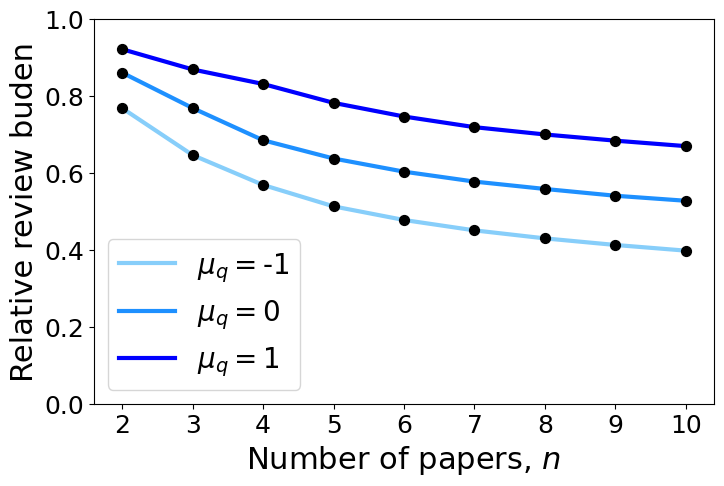

In [13]:
import numpy as np
color_list = ['lightskyblue' ,'dodgerblue', 'blue', 'navy']
mu_list = [-1,0,1]

x = n_list
plt.figure(figsize=(8,5))
for i,mu_q in enumerate(mu_list):
    y = np.zeros(len(n_list))
    for j,n in enumerate(n_list):
        y[j] = find_t_min(Rev_n_seq[i,j], Acc_q_seq[i,j], np.max(Acc_q_pal[i,j]))
    plt.plot(x,(y/np.array(x)), linewidth = 3, color = color_list[i], label = r'$\mu_q=$'+str(mu_q), zorder=0)
    plt.scatter(x,(y/np.array(x)), s = 50, color = 'black')
        
plt.xlabel(r'Number of papers, $n$', fontsize = '22')
plt.ylabel(r'Relative review buden', fontsize = '22')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize = 20)
plt.ylim(0,1)


(-2.0, 2.6)

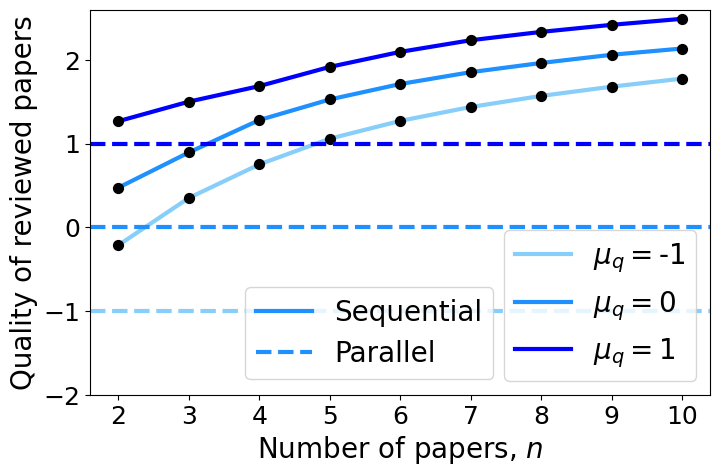

In [14]:
import numpy as np
color_list = ['lightskyblue' ,'dodgerblue', 'blue', 'navy']
mu_list = [-1,0,1]

x = n_list
plt.figure(figsize=(8,5))
for i,mu_q in enumerate(mu_list):
    y = np.zeros(len(n_list))
    for j,n in enumerate(n_list):
        y[j] = find_t_max(Rev_q_seq[i,j], Acc_q_seq[i,j], np.max(Acc_q_pal[i,j]))
    
    if i == 1:
        seq, = plt.plot(x,(y), linewidth = 3, color = color_list[i], label = r'$\mu_q=$'+str(mu_q), zorder=0)
        pal = plt.axhline(y=mu_q, linewidth = 3, linestyle = '--', color = color_list[i],)
        plt.scatter(x,(y), s = 50, color = 'black')
    else:
        plt.scatter(x,(y), s = 50, color = 'black')
        plt.plot(x,(y), linewidth = 3, color = color_list[i], label = r'$\mu_q=$'+str(mu_q), zorder=0)
        plt.axhline(y=mu_q, linewidth = 3, linestyle = '--', color = color_list[i],)
        
plt.xlabel(r'Number of papers, $n$', fontsize = '20')
plt.ylabel(r'Quality of reviewed papers', fontsize = '20')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
legend2 = plt.legend([seq, pal], ['Sequential', 'Parallel'], fontsize = '20', loc = (0.25, 0.04))
plt.legend(fontsize = 20)
plt.gca().add_artist(legend2)
plt.ylim(-2,2.6)


In [16]:
"""
Varying sig_r (review noise)
"""
n = 5
mu_list = [-1,0,1]
sig_q = 3
sig_list = [0.5,1,1.5,2]
t_acc_list = np.arange(-1.5,2,0.1)

Acc_q_seq = np.zeros((len(mu_list), len(sig_list), len(t_acc_list)))
Rev_q_seq = np.zeros((len(mu_list), len(sig_list), len(t_acc_list)))
Rev_n_seq = np.zeros((len(mu_list), len(sig_list), len(t_acc_list)))
Acc_q_pal = np.zeros((len(mu_list), len(sig_list), len(t_acc_list)))

for i,mu_q in enumerate(mu_list):
    for j,sig_r in enumerate(sig_list):
        para = ThresholdConfParams(
                n = n,
                mu_q = mu_q,
                sig_q = sig_q,
                sig_r = sig_r
                )

        for k,t in enumerate(t_acc_list):
            samples = sample_q(para, 100000)
            Acc_q_seq[i,j,k], Rev_q_seq[i,j,k], Rev_n_seq[i,j,k] = sequential_quality(para, samples, t, t)
            Acc_q_pal[i,j,k] = parallel_quality(para, samples, t)

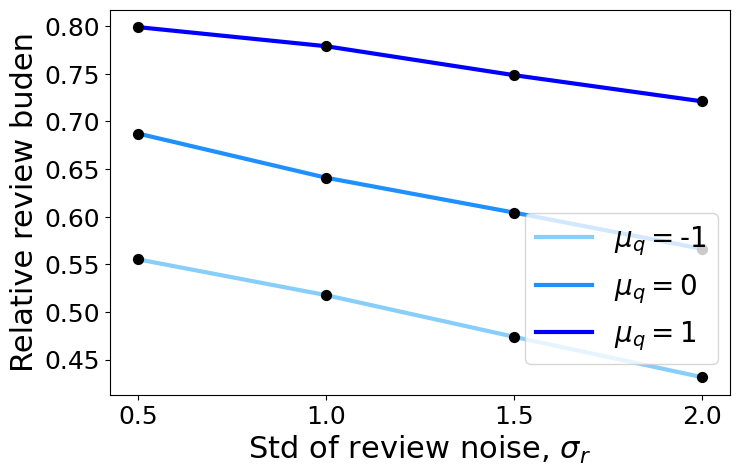

In [17]:
import numpy as np
color_list = ['lightskyblue' ,'dodgerblue', 'blue', 'navy']
mu_list = [-1,0,1]

sig_list = [0.5,1,1.5,2]
x = sig_list
plt.figure(figsize=(8,5))
for i,mu_q in enumerate(mu_list):
    y = np.zeros(len(sig_list))
    for j,sig_r in enumerate(sig_list):
        y[j] = find_t_min(Rev_n_seq[i,j], Acc_q_seq[i,j], np.max(Acc_q_pal[i,j]))

    plt.scatter(x,(y)/5, s = 50, color = 'black')
    plt.plot(x,(y)/5, linewidth = 3, color = color_list[i], label = r'$\mu_q=$'+str(mu_q), zorder=0)
        
plt.xlabel(r'Std of review noise, $\sigma_r$', fontsize = '22')
plt.ylabel(r'Relative review buden', fontsize = '22')
plt.xticks(sig_list, fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize = 20, loc = (0.67,0.08))
# plt.ylim(-1.2,1.7)


(-1.2, 2.4)

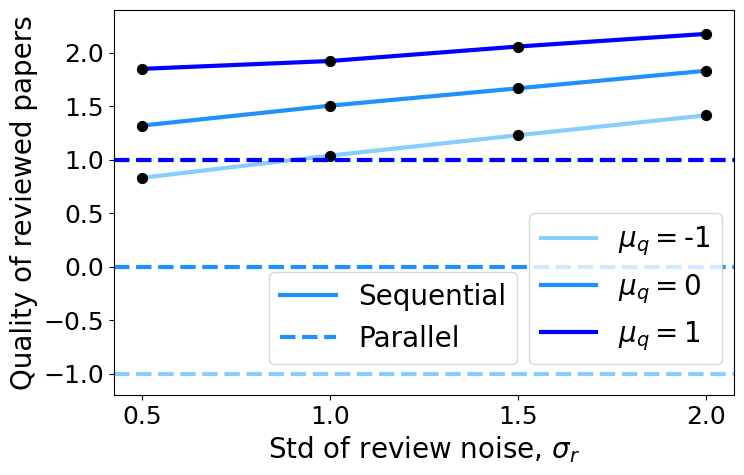

In [19]:
import numpy as np
color_list = ['lightskyblue' ,'dodgerblue', 'blue', 'navy']
mu_list = [-1,0,1]

sig_list = [0.5,1,1.5,2]
x = sig_list
plt.figure(figsize=(8,5))
for i,mu_q in enumerate(mu_list):
    y = np.zeros(len(sig_list))
    for j,sig_r in enumerate(sig_list):
        y[j] = find_t_max(Rev_q_seq[i,j], Acc_q_seq[i,j], np.max(Acc_q_pal[i,j]))
    
    if i == 1:
        seq, = plt.plot(x,(y), linewidth = 3, color = color_list[i], label = r'$\mu_q=$'+str(mu_q), zorder=0)
        pal = plt.axhline(y=mu_q, linewidth = 3, linestyle = '--', color = color_list[i],)
        plt.scatter(x,(y), s = 50, color = 'black')
    else:
        plt.scatter(x,(y), s = 50, color = 'black')
        plt.plot(x,(y), linewidth = 3, color = color_list[i], label = r'$\mu_q=$'+str(mu_q), zorder=0)
        plt.axhline(y=mu_q, linewidth = 3, linestyle = '--', color = color_list[i],)
        
plt.xlabel(r'Std of review noise, $\sigma_r$', fontsize = '20')
plt.ylabel(r'Quality of reviewed papers', fontsize = '20')
plt.xticks(sig_list, fontsize=18)
plt.yticks(fontsize=18)
legend2 = plt.legend([seq, pal], ['Sequential', 'Parallel'], fontsize = '20', loc = (0.25, 0.08))
plt.legend(fontsize = 20, loc = (0.67,0.08))
plt.gca().add_artist(legend2)
plt.ylim(-1.2,2.4)
